In [1]:
# !pip install --upgrade pip
# !pip install pandas numpy matplotlib yfinance seaborn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Optionally, set plotting style for clarity
plt.style.use('Solarize_Light2')

# Download historical data for the S&P 500.
# Here '^GSPC' is the ticker for the index.
data = yf.download('^GSPC', start='1995-01-01', progress=False)

# Resample to weekly data – here we use the last available price of each week.
# Using double brackets returns a DataFrame.
weekly_data = data[['Close']].resample('W').last()

# Rename the 'Close' column to 'Price'
weekly_data.rename(columns={'Close': 'Price'}, inplace=True)

# Display the first few rows
weekly_data.head()


YF.download() has changed argument auto_adjust default to True


Price,Price
Ticker,^GSPC
Date,
1995-01-08,460.679993
1995-01-15,465.970001
1995-01-22,464.779999
1995-01-29,470.390015
1995-02-05,478.649994


In [3]:
def RSI(series, period=14):
    """Calculate the Relative Strength Index (RSI) for a given series."""
    delta = series.diff()  # change in price
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    # Calculate average gains and losses
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    
    # Avoid division by zero
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Calculate the first-order RSI
weekly_data['RSI'] = RSI(weekly_data['Price'], 14)

# The second order RSI is calculated on the RSI values (note: many values will be NaN initially)
weekly_data['RSI2'] = RSI(weekly_data['RSI'], 14)

# Similarly, the third order RSI is computed on RSI2 values
weekly_data['RSI3'] = RSI(weekly_data['RSI2'], 14)

weekly_data.dropna(inplace=True)
weekly_data.head()


Price,Price,RSI,RSI2,RSI3
Ticker,^GSPC,,,
Date,,,,
1995-10-29,579.700012,70.273643,44.588902,61.125855
1995-11-05,590.570007,70.977544,41.293568,55.039473
1995-11-12,592.719971,76.374125,54.492257,68.000563
1995-11-19,600.070007,83.274144,68.120247,74.509016
1995-11-26,599.969971,82.064152,66.877377,73.564225


In [4]:
def simulate_strategy(prices, signal_series, investment_amount=100, threshold=30):
    """
    Simulate an investment strategy with timing.
    
    Each week, you contribute a fixed cash amount (investment_amount).
    When the signal (RSI, RSI2, or RSI3) is below the oversold threshold,
    invest all accumulated cash at that week's price.
    
    Returns:
      - list of portfolio values over time (shares * current price)
      - list of accumulated cash balances
      - final number of shares held in the portfolio
    """
    shares = 0.0       # total shares owned
    cash = 0.0         # cash accumulation waiting to be invested
    portfolio_values = []  # record the portfolio value each week
    cash_history = []      # record the cash accumulation each week

    for price, signal in zip(prices, signal_series):
        # Contribute fixed investment weekly
        cash += investment_amount

        # If the signal meets the oversold criteria, invest all accumulated cash
        if signal < threshold:
            shares += cash / price
            cash = 0.0   # reset cash after investing
        # Calculate current portfolio value (shares * current price)
        portfolio_values.append(shares * price)
        cash_history.append(cash)
        
    return portfolio_values, cash_history, shares


In [5]:
# Set the fixed weekly investment amount and the oversold threshold
investment_amount = 100
oversold_threshold = 40

# Extract and ensure our 'Price' column is a one-dimensional Series
prices = weekly_data['Price']
if isinstance(prices, pd.DataFrame):
    prices = prices.squeeze()  # Convert a one-column DataFrame to a Series
prices = pd.to_numeric(prices, errors='coerce')  # Now ensure it's numeric

# Do the same for the RSI columns in case they're not read in as Series
rsi = weekly_data['RSI']
if isinstance(rsi, pd.DataFrame):
    rsi = rsi.squeeze()
rsi = pd.to_numeric(rsi, errors='coerce')

rsi2 = weekly_data['RSI2']
if isinstance(rsi2, pd.DataFrame):
    rsi2 = rsi2.squeeze()
rsi2 = pd.to_numeric(rsi2, errors='coerce')

rsi3 = weekly_data['RSI3']
if isinstance(rsi3, pd.DataFrame):
    rsi3 = rsi3.squeeze()
rsi3 = pd.to_numeric(rsi3, errors='coerce')

# Strategy 1: Regular Dollar–Cost Averaging (invest every week)
shares_simple = 0.0
portfolio_simple = []
for price in prices:
    shares_simple += investment_amount / price
    portfolio_simple.append(shares_simple * price)

# Strategy 2: Invest when standard RSI < 30
portfolio_rsi, cash_rsi, final_shares_rsi = simulate_strategy(prices, rsi, 
                                                              investment_amount, oversold_threshold)

# Strategy 3: Invest when second order RSI (RSI2) < 30
portfolio_rsi2, cash_rsi2, final_shares_rsi2 = simulate_strategy(prices, rsi2, 
                                                                 investment_amount, oversold_threshold)

# Strategy 4: Invest when third order RSI (RSI3) < 30
portfolio_rsi3, cash_rsi3, final_shares_rsi3 = simulate_strategy(prices, rsi3, 
                                                                 investment_amount, oversold_threshold)


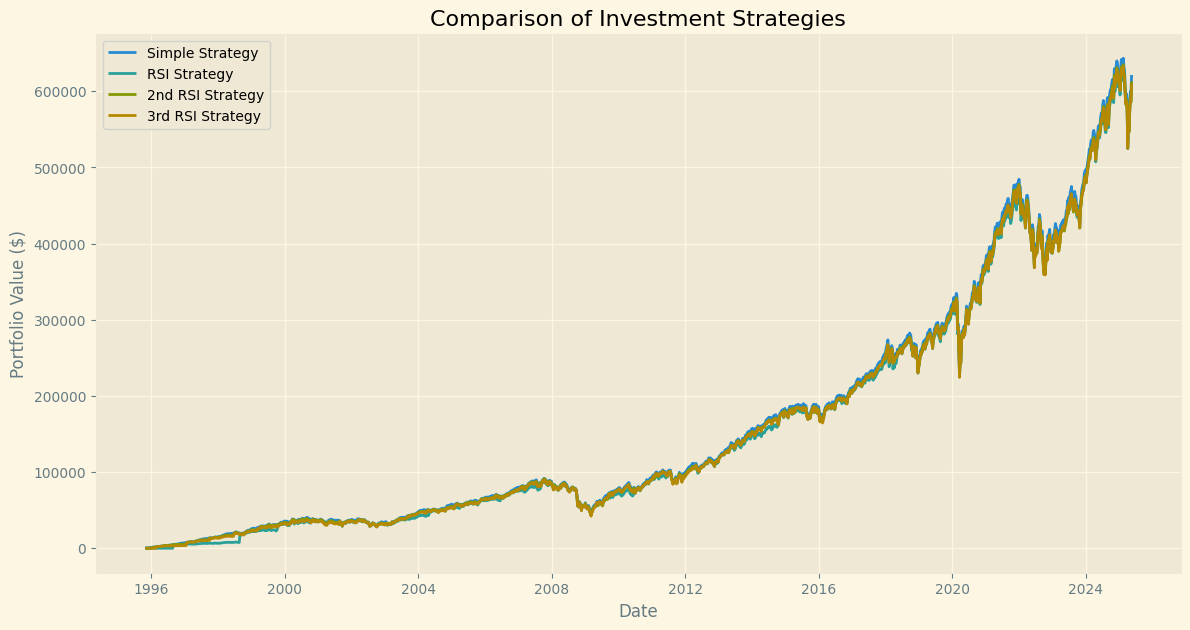

Final Portfolio Values:
Simple Strategy: $621402.05
RSI Strategy: $609781.45
2nd RSI Strategy: $613098.28
3rd RSI Strategy: $609786.69


In [6]:
# Combine portfolio values into a DataFrame for direct comparison.
results = pd.DataFrame({
    'Price': prices,
    'Simple Strategy': portfolio_simple,
    'RSI Strategy': portfolio_rsi,
    '2nd RSI Strategy': portfolio_rsi2,
    '3rd RSI Strategy': portfolio_rsi3,
}, index=weekly_data.index)

# Plot the portfolio values over time.
plt.figure(figsize=(14,7))
plt.plot(results.index, results['Simple Strategy'], label='Simple Strategy')
plt.plot(results.index, results['RSI Strategy'], label='RSI Strategy')
plt.plot(results.index, results['2nd RSI Strategy'], label='2nd RSI Strategy')
plt.plot(results.index, results['3rd RSI Strategy'], label='3rd RSI Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Comparison of Investment Strategies')
plt.legend()
plt.show()

# Print final portfolio values
print("Final Portfolio Values:")
print("Simple Strategy: ${:.2f}".format(results['Simple Strategy'].iloc[-1]))
print("RSI Strategy: ${:.2f}".format(results['RSI Strategy'].iloc[-1]))
print("2nd RSI Strategy: ${:.2f}".format(results['2nd RSI Strategy'].iloc[-1]))
print("3rd RSI Strategy: ${:.2f}".format(results['3rd RSI Strategy'].iloc[-1]))
